In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
from os import listdir
from os.path import isfile, join

import numpy as np
import matplotlib.pyplot as plt
import madmom

import sys
sys.path.append('../src')
from preprocessing import get_dataset
from models import OLSPatchRegressor
import visualize
MUSIC = 1
SPEECH = 0

na = np.newaxis

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/home/niels/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [3]:
music_dir  = '../data/music_speech/music_wav/'
speech_dir = '../data/music_speech/speech_wav/'

max_samples = -1

X, Y = get_dataset(music_dir, speech_dir, num_samples=max_samples, hpool=0, wpool=0)
print('Train Set Shape')
print(X.shape, Y.shape)

Y = (Y + 1) / 2 

loaded from disk
Train Set Shape
(128, 74, 1500, 1) (128,)


# Train CNN using KERAS

We now only use a convolution, so we have a linear model

In [4]:
batch_size = 8
num_classes = 2
epochs = 109

# --------------------------------------------
num_frequencies = X.shape[1]
num_timesteps   = X.shape[2]
num_channels    = X.shape[3]
filter_time_size = 10
input_shape = num_frequencies, num_timesteps, num_channels

# DEFINE MODEL
model = Sequential()
model.add(Conv2D(1, kernel_size=(num_frequencies, filter_time_size),
                 activation='sigmoid',
                 input_shape=input_shape))

model.add(Lambda(lambda x: K.mean(x, axis=[1,2])))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
t_ind = 96
XTrain = X[:t_ind]
YTrain = Y[:t_ind]
XTest  = X[t_ind:]
YTest  = Y[t_ind:]

print(XTrain.shape, YTrain.shape)
print(XTest.shape, YTest.shape)

(96, 74, 1500, 1) (96,)
(32, 74, 1500, 1) (32,)


In [8]:
model.fit(XTrain, YTrain,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(XTest, YTest))
score = model.evaluate(XTest, YTest, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 96 samples, validate on 32 samples
Epoch 1/10
96/96 [==============================] - 3s 27ms/step - loss: 0.5180 - acc: 0.8646 - val_loss: 0.5495 - val_acc: 0.6875
Epoch 2/10
96/96 [==

In [ ]:
model_path = '../models/keras/'
os.makedirs(model_path, exist_ok=True)

model.save(os.path.join(model_path, 'linear_on_spectros_width{}-{:2.2f}.h5'.format(filter_size, score[1])))

Y_p (2, 1491)
y_time (1491,)


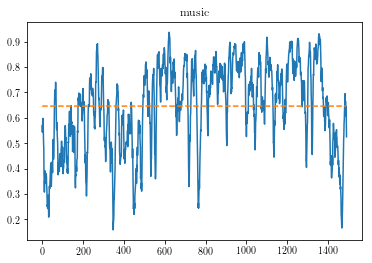

y_time (1491,)


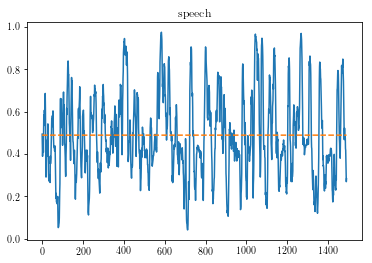

music (74, 1500, 1)
w_speech (1, 1500, 1)
audio (74, 1500, 1)
y (1491,)


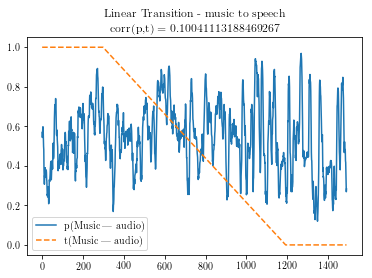

<Figure size 432x288 with 0 Axes>

In [39]:
music = XTest[YTest == MUSIC][1]
speech = XTest[YTest == SPEECH][1]
visualize.prediction_over_time(music, speech, model)